### Blob Detection using Laplacians of Gaussian and scale-space extrema detection

(-0.5, 359.5, 359.5, -0.5)

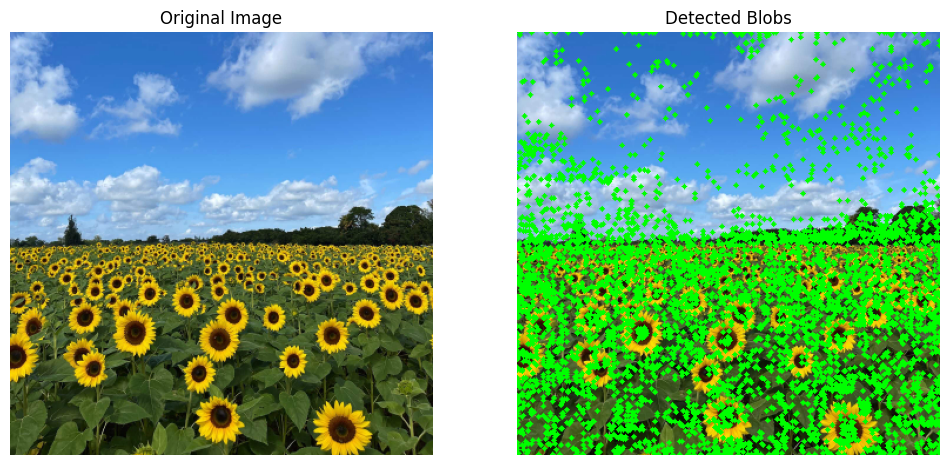

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Load an image
image = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Generate blurred images to detect blobs at different scales
sigma_values = np.linspace(1, 50, 10)
blured_images = [cv.GaussianBlur(img_gray, (0, 0), sigma) for sigma in sigma_values]

# Compute the Laplacian of Gaussian 
blobs_log = [cv.Laplacian(img, cv.CV_64F) for img in blured_images]

threshold = 2.98
# Find local extrema across the scale
def blob_detector(images,sigma_values,threshold):
    blobs = []
    blob_radii = []

    for i in range(1, len(images)-1):
        cur, prev, nxt = images[i], images[i-1], images[i+1]
        extrema = np.logical_and(np.logical_and(cur > prev, cur > nxt), cur > threshold)
        y_x = np.argwhere(extrema)  # centers of the blobs
        if y_x.size > 0:
            blobs.append(y_x)
            blob_radii.append(sigma_values[i] * np.sqrt(2))  # Append radii for each detected blob

    return blobs, blob_radii

blobs, blob_radii = blob_detector(blobs_log, sigma_values, threshold)

output_image = image.copy()
output_image = cv.cvtColor(output_image,cv.COLOR_BGR2RGB)

# Draw circles around detected blobs
for i, centers in enumerate(blobs):
    for center in centers:
        cv.circle(output_image, (int(center[1]), int(center[0])), 2, (0, 255, 0), -1)

# Display the image with detected blobs
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_rgb, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(output_image, cmap='gray', vmin=0, vmax=255)
ax[1].set_title('Detected Blobs')
ax[1].axis('off')



### Fitting lines

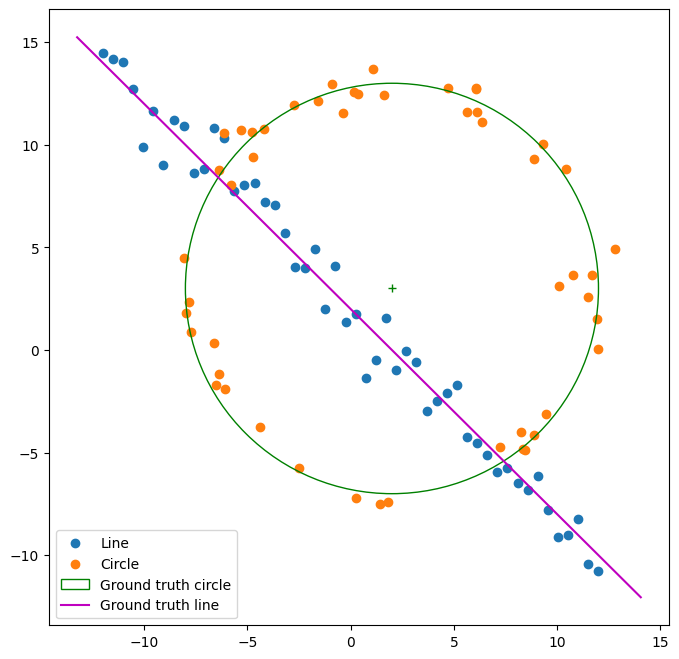

In [60]:
#Listing 1 to generate noisy points
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np . random . seed ( 0 )
N = 100
half_n = N//2

r = 10
x0_gt,y0_gt = 2,3 # Center
s = r/16
t = np.random.uniform(0,2*np.pi,half_n)
n = s*np.random.randn(half_n)
x,y = x0_gt + (r + n)*np.cos(t),y0_gt + (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1)))
s = 1.
m,b = -1, 2
x = np.linspace (-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack ((x.reshape(half_n, 1), y.reshape(half_n,1)))
X = np.vstack((X_circ, X_line)) # All points
fig , ax = plt.subplots(1 ,1 , figsize=(8 ,8))
ax.scatter(X_line[:, 0], X_line[:, 1], label= 'Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label= 'Circle')
circle_gt = plt.Circle((x0_gt , y0_gt), r, color= 'g' , fill = False , label= 'Ground truth circle' )
ax.add_patch (circle_gt)
ax.plot ((x0_gt ) , (y0_gt) , '+' , color= 'g')
x_min , x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_+b
plt . plot(x_, y_ ,color= 'm' , label= 'Ground truth line' )
plt . legend ( )

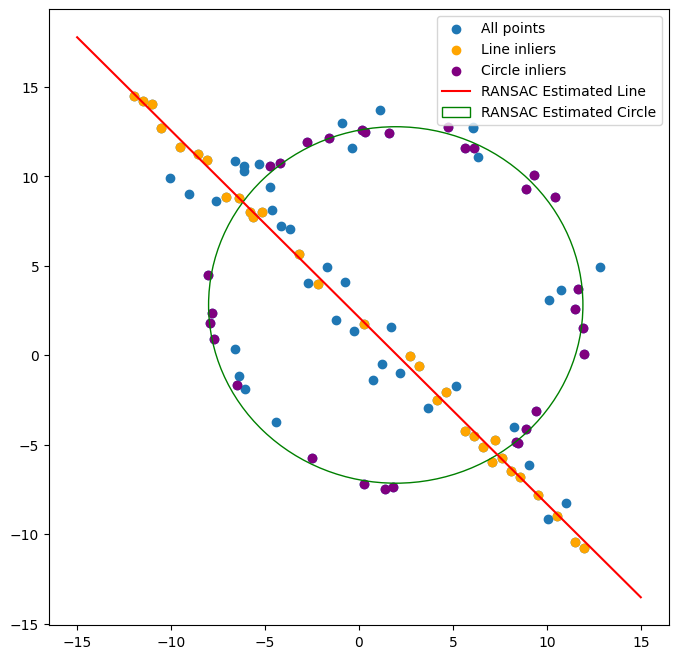

In [64]:
def estimate_circle_ransac(X, threshold, iterations):
    best_inliers = []
    best_circle = None

    for _ in range(iterations):
        # Randomly sample three points to define a circle
        sample_indices = np.random.choice(X.shape[0], 3, replace=False)
        pts = X[sample_indices]

        # Estimate circle parameters using the three points
        A = 2 * (pts[1] - pts[0])
        B = 2 * (pts[2] - pts[0])
        C = np.array([np.sum(pts[1]**2 - pts[0]**2), np.sum(pts[2]**2 - pts[0]**2)])

        try:
            center = np.linalg.solve(np.array([A, B]), C)
            radius = np.linalg.norm(center - pts[0])
        except np.linalg.LinAlgError:
            continue

        # Compute distances to the circle and count inliers
        distances = np.abs(np.sqrt((X[:, 0] - center[0])**2 + (X[:, 1] - center[1])**2) - radius)
        inliers = X[distances < threshold]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_circle = (center, radius)

    return best_circle[0], best_circle[1], np.array(best_inliers)

# Main execution
params_line, line_inliers = estimate_line_ransac(X, threshold=0.5, iterations=1000)
center_circle, radius_circle, circle_inliers = estimate_circle_ransac(X[~np.isin(X, line_inliers).all(axis=1)], threshold=0.5, iterations=1000)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='All points')
ax.scatter(line_inliers[:, 0], line_inliers[:, 1], label='Line inliers', color='orange')
ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], label='Circle inliers', color='purple')

# Plot line
a, b, d = params_line
x_line = np.linspace(-15, 15, 100)
y_line = -(a * x_line + d) / b
ax.plot(x_line, y_line, color='red', label='RANSAC Estimated Line')

# Plot circle
circle = plt.Circle(center_circle, radius_circle, color='green', fill=False, label='RANSAC Estimated Circle')
ax.add_patch(circle)

plt.legend()
plt.show()


### Superimpose images

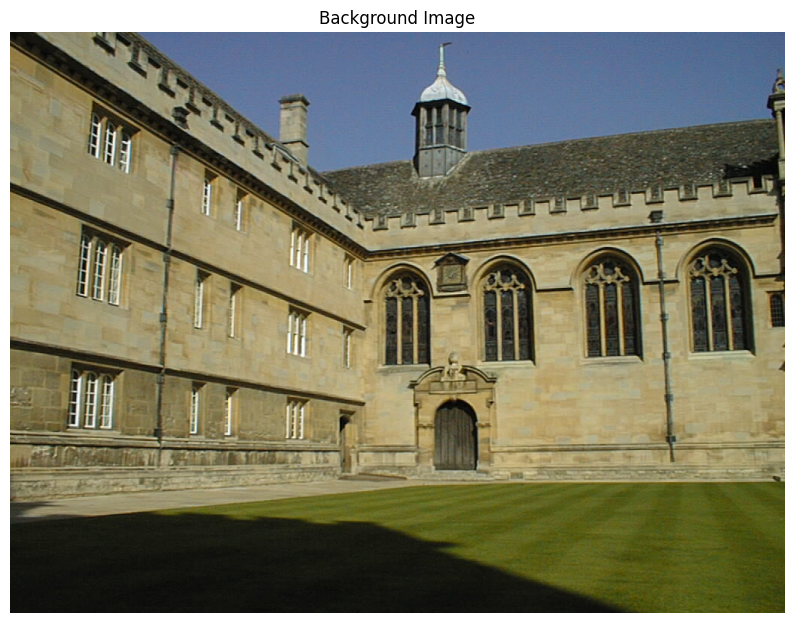

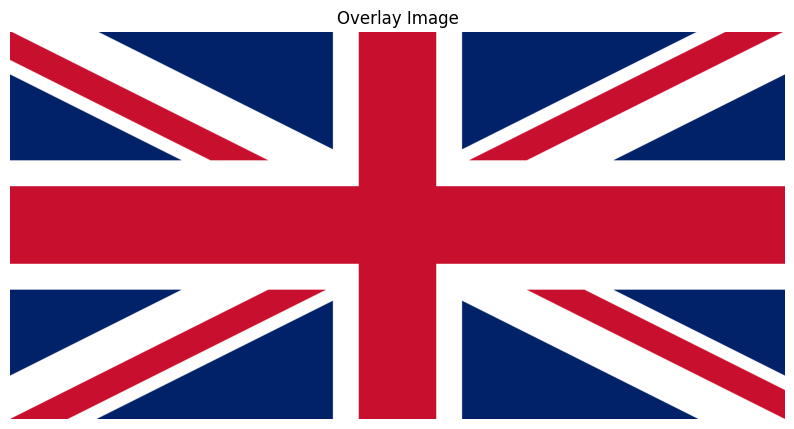

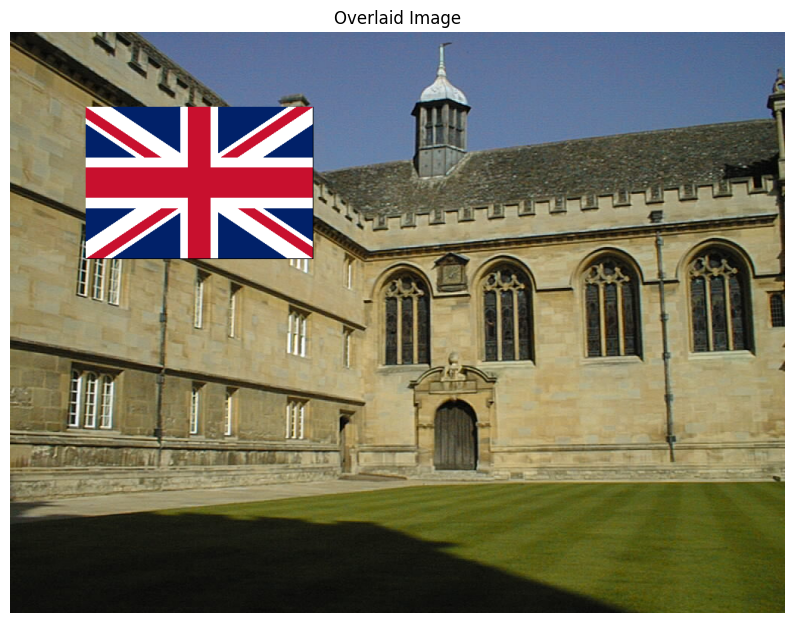

True

In [65]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_image(background_img, overlay_img, points):
    """
    Overlays an image onto a specific plane of a background image.
    
    Parameters:
    - background_img: The background image as a NumPy array.
    - overlay_img: The image to overlay as a NumPy array.
    - points: List of four points (x, y) representing the plane in the background image.
    """
    # Define the points for the overlay image (full rectangle of the overlay image)
    h, w = overlay_img.shape[:2]
    overlay_points = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype='float32')
    
    # Ensure the points list is in the correct shape (4 corners in clockwise or counterclockwise order)
    points = np.array(points, dtype='float32')
    
    # Compute the homography matrix
    homography_matrix, _ = cv2.findHomography(overlay_points, points)

    # Warp the overlay image to the background using the homography matrix
    warped_overlay = cv2.warpPerspective(overlay_img, homography_matrix, 
                                         (background_img.shape[1], background_img.shape[0]))
    
    # Create a mask of the overlay image
    mask = np.zeros_like(background_img, dtype='uint8')
    cv2.fillConvexPoly(mask, points.astype(int), (255, 255, 255))

    # Invert the mask to black out the area on the background image where overlay will be placed
    inverted_mask = cv2.bitwise_not(mask)
    background_img_blackout = cv2.bitwise_and(background_img, inverted_mask)

    # Add the warped overlay to the blacked-out background image
    final_image = cv2.add(background_img_blackout, warped_overlay)

    return final_image

def display_image(image, title="Image"):
    """Helper function to display an image using matplotlib."""
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load images
background_image_path = 'Images/005.jpg'
overlay_image_path = 'Images/flag.png'

# Load the images using OpenCV
background_img = cv2.imread(background_image_path)
overlay_img = cv2.imread(overlay_image_path)

# Display the input images
display_image(background_img, "Background Image")
display_image(overlay_img, "Overlay Image")

# Specify the four points on the background image where you want to overlay (order: top-left, top-right, bottom-right, bottom-left)
points_on_background = [(100, 100), (400, 100), (400, 300), (100, 300)]

# Perform the overlay operation
result_image = overlay_image(background_img, overlay_img, points_on_background)

# Display the result
display_image(result_image, "Overlaid Image")

# Save the result if desired
cv2.imwrite('overlaid_image.jpg', result_image)